# Convolutional Neural Network on MNIST

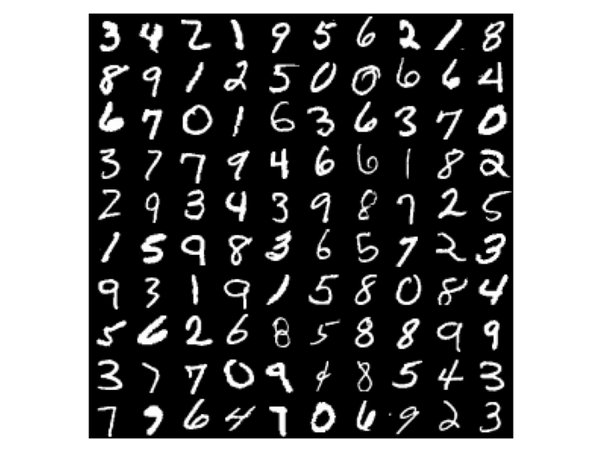

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
from copy import deepcopy

# Reproducability and Image Normalization

In [2]:
# Set random seed for reproducibility
random_seed = 1

# For reproducibility, this turns off cudnn's auto-tuner.
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
n_epochs = 3
batch_size_train = 64
batch_size_test = 64
learning_rate = 0.01

In [3]:
# Data Hyperparameters
global_mean = 0.1307 # MNIST train dataset mean
global_std = 0.3081 # MNIST train dataset standard deviation

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((global_mean), (global_std)),
])

In [4]:
data_path = 'datasets/mnst'

if not os.path.exists(data_path):
    download = True
else:
    download = False

train_loader = DataLoader(
    torchvision.datasets.MNIST(
        data_path,
        train=True,
        download=download,
        transform=transform,
        ),
    batch_size=batch_size_train,
    shuffle=True,
    )

val_loader = DataLoader(
    torchvision.datasets.MNIST(
        data_path,
        train=False, 
        download=download,
        transform=transform,
        ),
    batch_size=batch_size_test,
    shuffle=False,
    )

Batch index: 0
Input batch shape: torch.Size([64, 1, 28, 28])
Target batch shape: torch.Size([64])


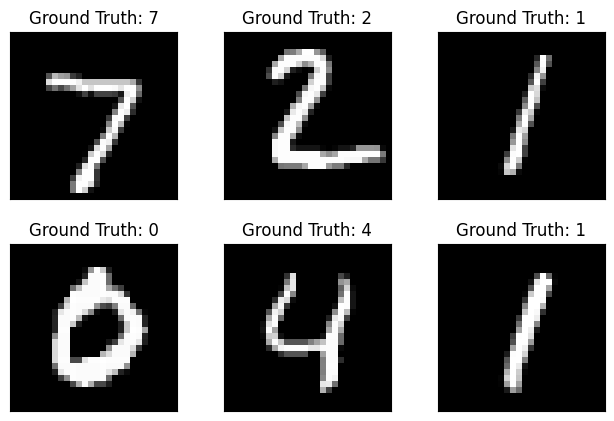

In [5]:
batch = enumerate(val_loader)
batch_idx, (example_data, example_targets) = next(batch)
print(f"Batch index: {batch_idx}")
print(f"Input batch shape: {example_data.shape}")
print(f"Target batch shape: {example_targets.shape}")

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

### Building the Network

In [6]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self, input_size=1, n_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=input_size, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_dropout1 = nn.Dropout2d(p=0.2)
        self.fc1 = nn.Linear(32*14*14, 128)
        self.fc_dropout1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(128, n_classes)

        # Initialize weights
        init.kaiming_uniform_(self.conv1.weight, nonlinearity='relu')
        init.constant_(self.conv1.bias, 0)
        init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        init.constant_(self.fc1.bias, 0)
        init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        init.constant_(self.fc2.bias, 0)
        
    def forward(self, x):
        # Shape: (batch_size, 1, 28, 28) -> (batch_size, 32, 14, 14)
        x = F.relu(F.max_pool2d(self.conv_dropout1(self.conv1(x)), 2))
        # Shape: (batch_size, 32, 14, 14) -> (batch_size, 32*14*14)
        x = x.view(-1, 32*14*14)
        # Shape: (batch_size, 32*14*14) -> (batch_size, 64)
        x = F.relu(self.fc_dropout1(self.fc1(x)))
        # Shape: (batch_size, 64) -> (batch_size, n_classes)
        x = self.fc2(x)
        return x

Let's also try a U-Net architecture. This is a convolutional neural network that was developed for biomedical image segmentation at the Computer Science Department of the University of Freiburg, Germany. The network is based on the fully convolutional network and its architecture was modified and extended to work with fewer training images and to yield more precise segmentations.

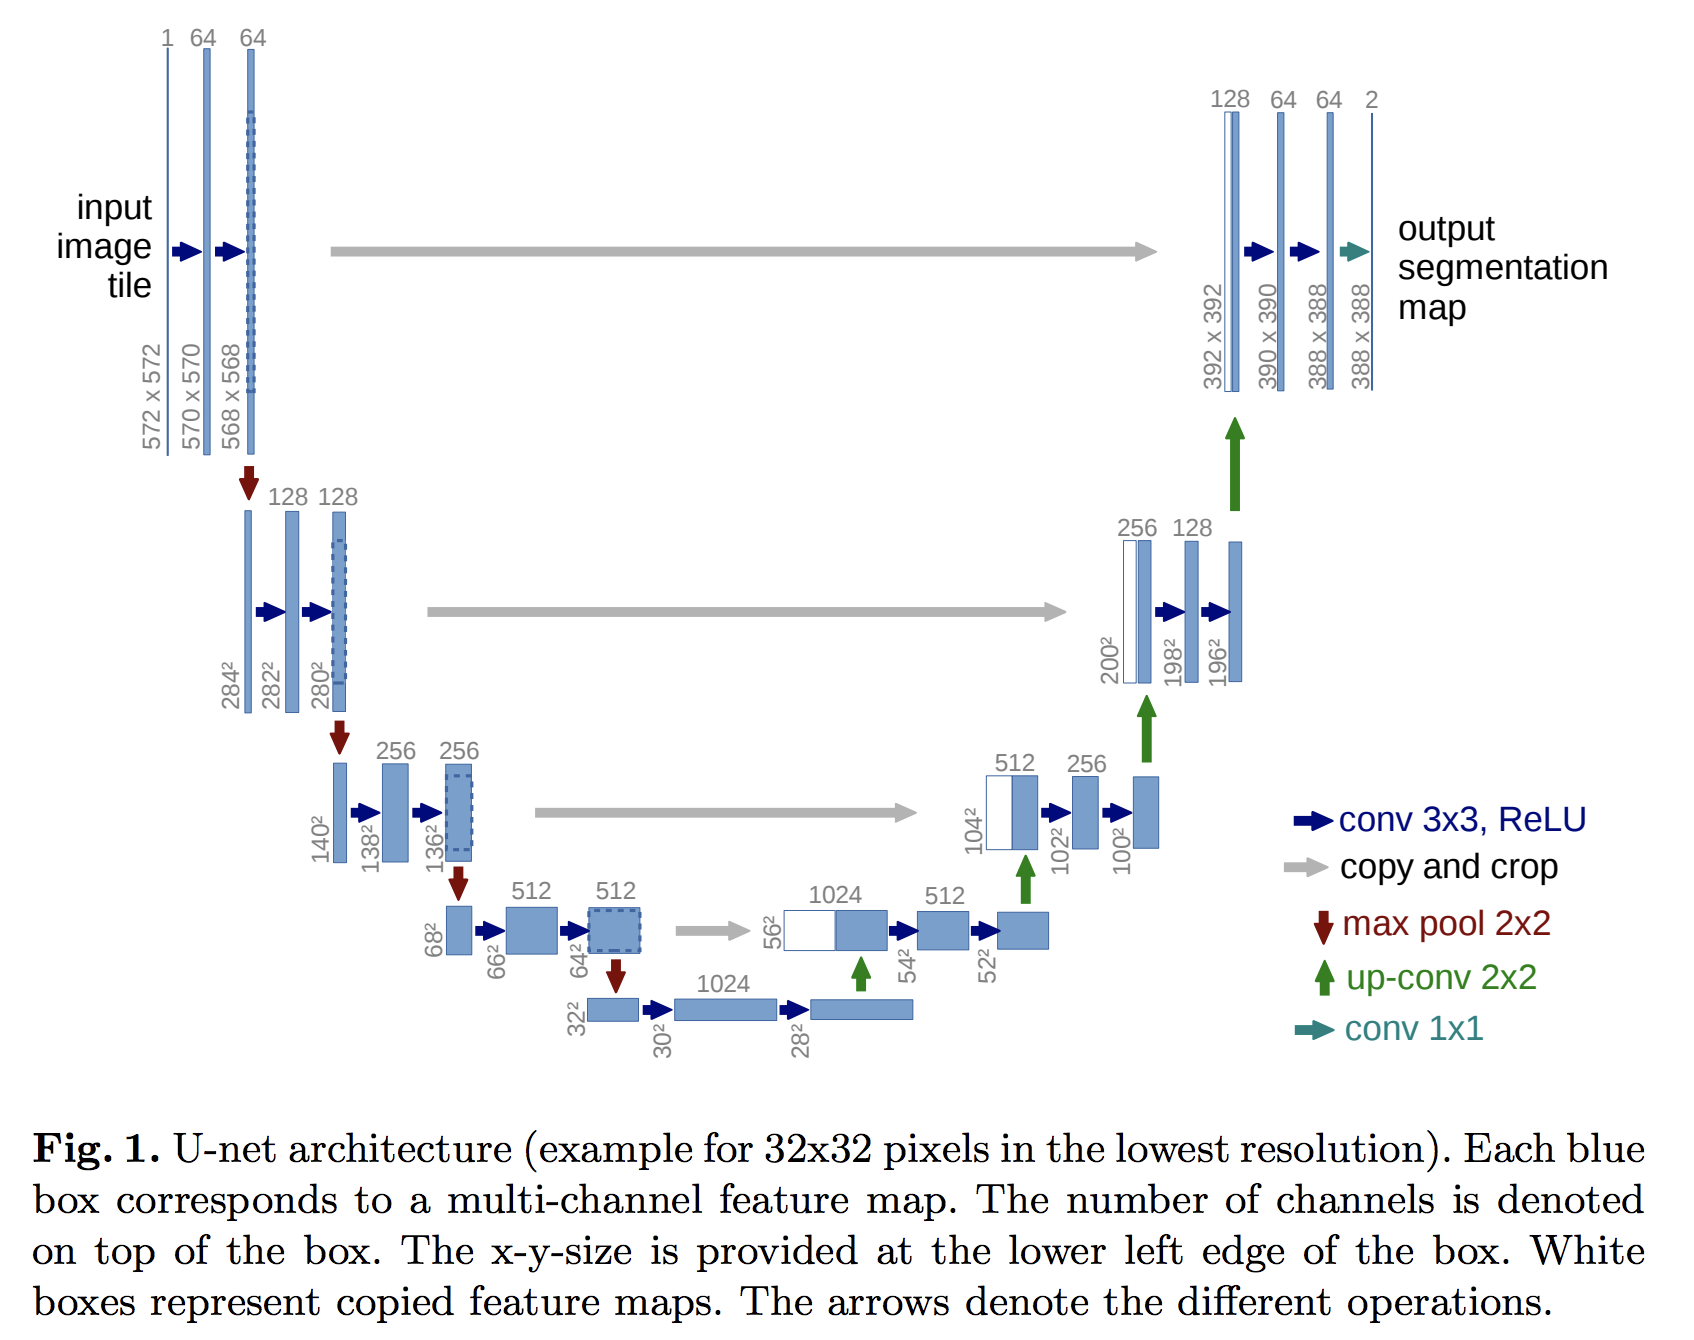

In [7]:
class UNet(nn.Module):
  def __init__(self):
    super().__init__()
    x, y = (1, 128, 128), 10
    c, h, w = x

    # nn.Conv2d(Channelin, Channel_Out, Kernel Size, Stride, Padding)
    # Downsize Block 1
    self.Conv01 = nn.Conv2d(c, 64, kernel_size = 3, stride=(1,1), padding = (1,1))
    self.Conv02 = nn.Conv2d(64, 64, kernel_size = 3, stride=(1,1), padding = (1,1))
    self.Conv03 = nn.Conv2d(64, 64, kernel_size = 3, stride=(1,1),  padding = (1,1))

    # Downsize Block 2
    self.Conv04 = nn.Conv2d(64, 128, kernel_size = 3, stride=(1,1),  padding=(1,1))
    self.Conv05 = nn.Conv2d(128, 128, kernel_size = 3, stride=(1,1),  padding=(1,1))
    self.Conv06 = nn.Conv2d(128, 128, kernel_size = 3, stride=(1,1),  padding=(1,1))

    # Downsize Block 3
    self.Conv07 = nn.Conv2d(128, 256, kernel_size = 3, stride=(1,1),  padding=(1,1))
    self.Conv08 = nn.Conv2d(256, 256, kernel_size = 3, stride=(1,1),  padding=(1,1))
    self.Conv09 = nn.Conv2d(256, 256, kernel_size = 3, stride=(1,1),  padding=(1,1))

    # Downsize Block 4
    self.Conv10 = nn.Conv2d(256, 512, kernel_size = 3, stride=(1,1),  padding=(1,1))
    self.Conv11 = nn.Conv2d(512, 512, kernel_size = 3, stride=(1,1),  padding=(1,1))
    self.Conv12 = nn.Conv2d(512, 512, kernel_size = 3, stride=(1,1),  padding=(1,1))
    
    # Center Block 5
    self.Conv13 = nn.Conv2d(512, 1024, kernel_size = 3, stride=(1,1),  padding=(1,1))
    self.Conv14 = nn.Conv2d(1024, 1024, kernel_size = 3, stride=(1,1),  padding=(1,1))    
    self.Conv15 = nn.ConvTranspose2d(1024, 512, kernel_size = 2, stride=(2,2), padding=(0,0))
    
    # Upsize Block 6
    self.Conv16 = nn.Conv2d(1024, 512, kernel_size = 3, stride=(1,1),  padding=(1,1))
    self.Conv17 = nn.Conv2d(512, 512, kernel_size = 3, stride=(1,1),  padding=(1,1))
    self.Conv18 = nn.ConvTranspose2d(512, 256, kernel_size = 2, stride=(2,2),  padding=(0,0))

    # Upsize Block 7
    self.Conv19 = nn.Conv2d(512, 256, kernel_size = 3, stride=(1,1),  padding=(1,1))
    self.Conv20 = nn.Conv2d(256, 256, kernel_size = 3, stride=(1,1),  padding=(1,1))
    self.Conv21 = nn.ConvTranspose2d(256, 128, kernel_size = 2, stride=(2,2),  padding=(0,0))

    # Upsize Block 8
    self.Conv22 = nn.Conv2d(256, 128, kernel_size = 3, stride=(1,1),  padding=(1,1))
    self.Conv23 = nn.Conv2d(128, 128, kernel_size = 3, stride=(1,1),  padding=(1,1))
    self.Conv24 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride=(2,2),  padding=(0,0))

    # Upsize Block 9
    self.Conv25 = nn.Conv2d(128, 64, kernel_size = 3, stride=(1,1), padding=(1,1))
    self.Conv26 = nn.Conv2d(64, 64, kernel_size = 3, stride=(1,1), padding=(1,1))
    self.Conv27 = nn.Conv2d(64, 1, kernel_size = 1) # Shape: 1x28x28

    # Fully Connected Layer
    self.fc1 = nn.Linear(64 * (h // 16) * (w // 16), 128)
    self.fc2 = nn.Linear(128, 10)

  def Block_Conv_Downsize(self, conv0, conv1, conv2, x):
    #Block 1-4
    output1 = F.relu(conv0(x))
    output2 = F.relu(conv1(output1))
    output3 = F.max_pool2d(conv2(output2), 2)
    return output3, output2

  def Block_Conv_Center(self, conv0, conv1, conv2, x):
    #Block 5
    output1 = F.relu(conv0(x))
    output2 = F.relu(conv1(output1))
    output3 = conv2(output2)
    return output3

  def Block_Conv_Upsize(self, conv0, conv1, conv2, x, res_x):
    #Block 6-9 
    x = torch.cat((res_x, x), 1)
    output1 = F.relu(conv0(x))
    output2 = F.relu(conv1(output1))
    output3 = conv2(output2)   
    return output3

  def Block_Conv_Out(self, conv0, conv1, conv2, x, res_x):
    #Block 5-8
    x = torch.cat((res_x, x), 1)
    output1 = F.relu(conv0(x))
    output2 = F.relu(conv1(output1))
    output3 = conv2(output2) 
    return output3

  def forward(self, x):
    #DownSize
    x1, residual1 = self.Block_Conv_Downsize(self.Conv01, self.Conv02, self.Conv03, x)
    x2, residual2 = self.Block_Conv_Downsize(self.Conv04, self.Conv05, self.Conv06, x1)
    x3, residual3 = self.Block_Conv_Downsize(self.Conv07, self.Conv08, self.Conv09, x2)
    x4, residual4 = self.Block_Conv_Downsize(self.Conv10, self.Conv11, self.Conv12, x3)
    #Center
    x5 = self.Block_Conv_Center(self.Conv13, self.Conv14, self.Conv15, x4) 
    #Upsize
    x = self.Block_Conv_Upsize(self.Conv16, self.Conv17, self.Conv18, x, residual4)
    x = self.Block_Conv_Upsize(self.Conv19, self.Conv20, self.Conv21, x, residual3)
    x = self.Block_Conv_Upsize(self.Conv22, self.Conv23, self.Conv24, x, residual2)
    x = self.Block_Conv_Out(self.Conv25, self.Conv26, self.Conv27, x, residual1)
    x = self.fc1(x.view(-1, 64 * 28 * 28))
    x = self.fc2(x)
    return x

### Define training loop

In [8]:
def train_classification(model, data_loader, optimizer, criterion, device):
    model.to(device).train()
    batch_loss = []
    correct = 0
    total_samples = 0

    for x, y in data_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
        correct += (y_hat.argmax(1) == y).sum().item()
        total_samples += y.size(0)

    accuracy = 100.0 * correct / total_samples
    loss_total = sum(batch_loss) / len(batch_loss)

    return loss_total, accuracy


def validate_classification(model, data_loader, criterion, device):
    model.to(device).eval()
    batch_loss = []
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            batch_loss.append(loss.item())
            correct += (y_hat.argmax(1) == y).sum().item()
            total_samples += y.size(0)

    accuracy = 100.0 * correct / total_samples
    loss_total = sum(batch_loss) / len(batch_loss)

    return loss_total, accuracy

class EarlyStopper:
    def __init__(
        self, patience: int = 1, min_delta: float = 0.0, verbose: bool = False
    ):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float("inf")
        self.best_model_weights = None
        self.verbose = verbose

    def early_stop(self, loss:float, model:nn.Module):
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.counter = 0
            self.save_best_weights(model)
        else:
            self.counter += 1
            if self.verbose:
                print(f"Early Stopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                return True
        return False

    def save_best_weights(self, model):
        self.best_model_weights = deepcopy(model.state_dict())

    def restore_best_weights(self, model):
        model.load_state_dict(self.best_model_weights)

In [9]:
# Lists to store loss and accuracy
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []

# Training parameters
n_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate model, loss function, and optimizer
model = ConvolutionalNeuralNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
early_stopper = EarlyStopper(patience=5, min_delta=0.001)

In [10]:
for epoch in tqdm(range(n_epochs), desc='Training Progress'):
    epoch_train_loss, epoch_train_acc = train_classification(model, train_loader, optimizer, criterion, device)
    train_loss.append(epoch_train_loss)
    train_accuracy.append(epoch_train_acc)

    epoch_val_loss, epoch_val_acc = validate_classification(model, val_loader, criterion, device)
    val_loss.append(epoch_val_loss)
    val_accuracy.append(epoch_val_acc)

    print(f'[{epoch+1}/{n_epochs}] Train loss: {epoch_train_loss:.4f} acc: {epoch_train_acc:.2f}% - Val loss: {epoch_val_loss:.4f} acc: {epoch_val_acc:.2f}%')
    if early_stopper.early_stop(epoch_val_loss, model):
        early_stopper.restore_best_weights(model)
        print("Early Stopping triggered: Restoring best weights")
        break

Training Progress:  10%|█         | 1/10 [00:10<01:30, 10.03s/it]

[1/10] Train loss: 0.6979 acc: 85.42% - Val loss: 0.1078 acc: 96.77%


Training Progress:  20%|██        | 2/10 [00:21<01:25, 10.72s/it]

[2/10] Train loss: 0.2158 acc: 93.31% - Val loss: 0.0784 acc: 97.48%


Training Progress:  30%|███       | 3/10 [00:32<01:16, 10.87s/it]

[3/10] Train loss: 0.1757 acc: 94.69% - Val loss: 0.0764 acc: 97.57%


Training Progress:  40%|████      | 4/10 [00:43<01:05, 10.94s/it]

[4/10] Train loss: 0.1582 acc: 95.09% - Val loss: 0.0771 acc: 97.76%


Training Progress:  50%|█████     | 5/10 [00:54<00:54, 10.96s/it]

[5/10] Train loss: 0.1525 acc: 95.39% - Val loss: 0.0745 acc: 97.87%


Training Progress:  60%|██████    | 6/10 [01:05<00:44, 11.08s/it]

[6/10] Train loss: 0.1337 acc: 96.02% - Val loss: 0.0695 acc: 97.80%


Training Progress:  70%|███████   | 7/10 [01:17<00:33, 11.18s/it]

[7/10] Train loss: 0.1317 acc: 96.06% - Val loss: 0.1003 acc: 97.20%


Training Progress:  80%|████████  | 8/10 [01:28<00:22, 11.16s/it]

[8/10] Train loss: 0.1252 acc: 96.31% - Val loss: 0.0808 acc: 97.66%


Training Progress:  90%|█████████ | 9/10 [01:39<00:11, 11.13s/it]

[9/10] Train loss: 0.1207 acc: 96.50% - Val loss: 0.0988 acc: 97.30%


Training Progress: 100%|██████████| 10/10 [01:50<00:00, 11.04s/it]

[10/10] Train loss: 0.1111 acc: 96.79% - Val loss: 0.0821 acc: 97.76%


In [11]:
save = False
if save:
    torch.save(model.state_dict(), '/results/model.pth')
    torch.save(optimizer.state_dict(), '/results/optimizer.pth')

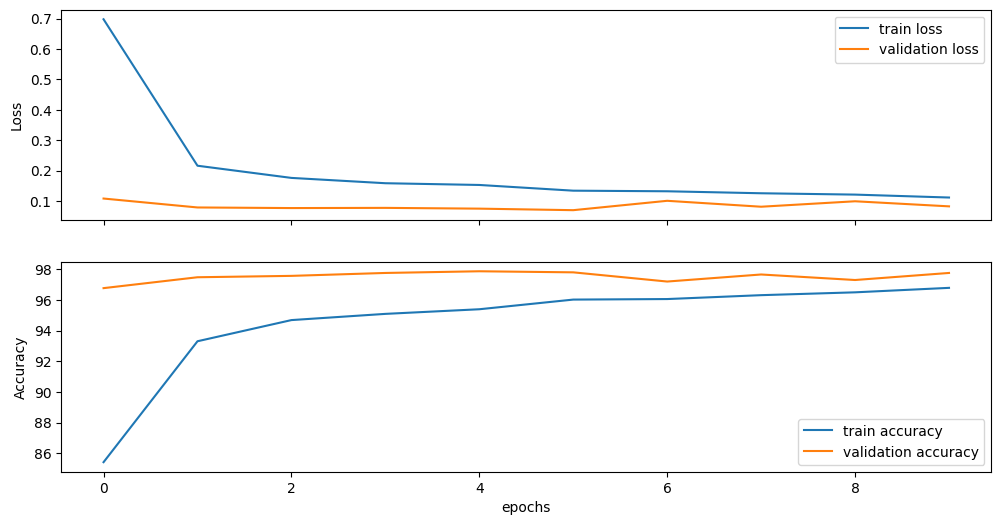

In [12]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(train_loss, label="train loss")
ax1.plot(val_loss, label="validation loss")
ax1.set_ylabel("Loss")
ax2.plot(train_accuracy, label="train accuracy")
ax2.plot(val_accuracy, label="validation accuracy")
ax2.set_ylabel("Accuracy")
ax2.set_xlabel("epochs")
ax1.legend()
ax2.legend()